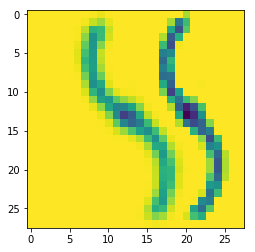

In [8]:
import numpy as np
import matplotlib.pyplot as plt
pic_s=np.load('pic_s.npy')
plt.imshow(pic_s[:,:,1])

In [80]:
pic_s[:,:,1].shape

(28, 28)

In [82]:
from scipy.signal import convolve2d

In [105]:
A=1-convolve2d(pic_s[:,:,1]/255,np.ones((5,5)),'valid')/25

In [106]:
B=1-convolve2d(pic_s[:,:,1]/255,np.ones((1,5)),'valid')/5

In [107]:
C=1-convolve2d(pic_s[:,:,1]/255,np.ones((5,1)),'valid')/5

In [108]:
D=1-convolve2d(pic_s[:,:,1]/255,np.eye(5),'valid')/5

In [109]:
EE=np.eye(5)
E=1-convolve2d(pic_s[:,:,1]/255,EE[::-1],'valid')/5

In [116]:
D.shape

(24, 24)

In [119]:
K=np.hstack((A.reshape(1,576),B.reshape(1,672),C.reshape(1,672),D.reshape(1,576),E.reshape(1,576)))
K.shape

(1, 3072)

In [58]:
#prepare data
#no softmax
def forward(self, x):
    """
    Forward propagates the network given an input batch
    How it works is...


    :param x: Inputs x (b, c, h, w)
    :return: preds (b, num_classes)
    """
    minibatch_size = x.shape[0]
    num_panels = x.shape[1]
    cnn_input_shape = (minibatch_size * num_panels, 1, self.input_shape[-2], self.input_shape[-1])
    out = x.view(cnn_input_shape) # reshape into (minibatch_size * 9, 1, h, w) as we don't convolute across panels

    # Beginning of CNN
    for i in range(self.num_layers):  # for number of CNN layers
        print(i,out.shape)
        out = self.layer_dict['conv_{}'.format(i)](out)  # pass through conv layer indexed at i
        out = F.relu(out)  # pass conv outputs through ReLU
        #out = self.batchnorm(out)
    return out

In [73]:
def forward(self, x):
    """
    Forward propages the network given an input batch
    :param x: Inputs x (b, c, h, w)
    :return: preds (b, num_classes)
    """
    out = x
    for i in range(self.num_layers):  # for number of layers

        out = self.layer_dict['conv_{}'.format(i)](out)  # pass through conv layer indexed at i
        out = F.relu(out)  # pass conv outputs through ReLU
        if self.dim_reduction_type == 'strided_convolution':  # if strided convolution dim reduction then
            out = self.layer_dict['dim_reduction_strided_conv_{}'.format(i)](
                out)  # pass previous outputs through a strided convolution indexed i
            out = F.relu(out)  # pass strided conv outputs through ReLU

        elif self.dim_reduction_type == 'dilated_convolution':
            out = self.layer_dict['dim_reduction_dilated_conv_{}'.format(i)](out)
            out = F.relu(out)

        elif self.dim_reduction_type == 'max_pooling':
            out = self.layer_dict['dim_reduction_max_pool_{}'.format(i)](out)

        elif self.dim_reduction_type == 'avg_pooling':
            out = self.layer_dict['dim_reduction_avg_pool_{}'.format(i)](out)
    return out

In [74]:
CN=ConvolutionalNetwork((1,1,28,28), 'max_pooling', 1, 5, 4, use_bias=False)

Building basic block of ConvolutionalNetwork using input shape (1, 1, 28, 28)
torch.Size([1, 5, 28, 28])
torch.Size([1, 5, 15, 15])
torch.Size([1, 5, 15, 15])
torch.Size([1, 5, 8, 8])
torch.Size([1, 5, 8, 8])
torch.Size([1, 5, 5, 5])
torch.Size([1, 5, 5, 5])
torch.Size([1, 5, 3, 3])
shape before final linear layer torch.Size([1, 5, 2, 2])
Block is built, output volume is torch.Size([1, 1])


In [76]:
x=torch.Tensor(pic_s[:,:,1].reshape(1,1,28,28)).float().to(device='cpu')
out=forward(CN, x)
out.shape

torch.Size([1, 5, 3, 3])

In [13]:
import torch.nn as nn

In [14]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self, input_shape, dim_reduction_type, num_output_classes, num_filters, num_layers, use_bias=False):
        """
        Initializes a convolutional network module object.
        :param input_shape: The shape of the inputs going in to the network.
        :param dim_reduction_type: The type of dimensionality reduction to apply after each convolutional stage, should be one of ['max_pooling', 'avg_pooling', 'strided_convolution', 'dilated_convolution']
        :param num_output_classes: The number of outputs the network should have (for classification those would be the number of classes)
        :param num_filters: Number of filters used in every conv layer, except dim reduction stages, where those are automatically infered.
        :param num_layers: Number of conv layers (excluding dim reduction stages)
        :param use_bias: Whether our convolutions will use a bias.
        """
        super(ConvolutionalNetwork, self).__init__()
        # set up class attributes useful in building the network and inference
        self.input_shape = input_shape
        self.num_filters = num_filters
        self.num_output_classes = num_output_classes
        self.use_bias = use_bias
        self.num_layers = num_layers
        self.dim_reduction_type = dim_reduction_type
        # initialize a module dict, which is effectively a dictionary that can collect layers and integrate them into pytorch
        self.layer_dict = nn.ModuleDict()
        # build the network
        self.build_module()

    def build_module(self):
        """
        Builds network whilst automatically inferring shapes of layers.
        """
        print("Building basic block of ConvolutionalNetwork using input shape", self.input_shape)
        x = torch.zeros((self.input_shape))  # create dummy inputs to be used to infer shapes of layers

        out = x
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True)
        for i in range(self.num_layers):  # for number of layers times
            self.layer_dict['conv_{}'.format(i)] = nn.Conv2d(in_channels=out.shape[1],
                                                             # add a conv layer in the module dict
                                                             kernel_size=3,
                                                             out_channels=self.num_filters, padding=1,
                                                             bias=self.use_bias)

            out = self.layer_dict['conv_{}'.format(i)](out)  # use layer on inputs to get an output
            out = F.relu(out)  # apply relu
            print(out.shape)
            if self.dim_reduction_type == 'strided_convolution':  # if dim reduction is strided conv, then add a strided conv
                self.layer_dict['dim_reduction_strided_conv_{}'.format(i)] = nn.Conv2d(in_channels=out.shape[1],
                                                                                       kernel_size=3,
                                                                                       out_channels=out.shape[1],
                                                                                       padding=1,
                                                                                       bias=self.use_bias, stride=2,
                                                                                       dilation=1)

                out = self.layer_dict['dim_reduction_strided_conv_{}'.format(i)](
                    out)  # use strided conv to get an output
                out = F.relu(out)  # apply relu to the output
            elif self.dim_reduction_type == 'dilated_convolution':  # if dim reduction is dilated conv, then add a dilated conv, using an arbitrary dilation rate of i + 2 (so it gets smaller as we go, you can choose other dilation rates should you wish to do it.)
                self.layer_dict['dim_reduction_dilated_conv_{}'.format(i)] = nn.Conv2d(in_channels=out.shape[1],
                                                                                       kernel_size=3,
                                                                                       out_channels=out.shape[1],
                                                                                       padding=1,
                                                                                       bias=self.use_bias, stride=1,
                                                                                       dilation=i + 2)
                out = self.layer_dict['dim_reduction_dilated_conv_{}'.format(i)](
                    out)  # run dilated conv on input to get output
                out = F.relu(out)  # apply relu on output

            elif self.dim_reduction_type == 'max_pooling':
                self.layer_dict['dim_reduction_max_pool_{}'.format(i)] = nn.MaxPool2d(2, padding=1)
                out = self.layer_dict['dim_reduction_max_pool_{}'.format(i)](out)

            elif self.dim_reduction_type == 'avg_pooling':
                self.layer_dict['dim_reduction_avg_pool_{}'.format(i)] = nn.AvgPool2d(2, padding=1)
                out = self.layer_dict['dim_reduction_avg_pool_{}'.format(i)](out)

            print(out.shape)
        if out.shape[-1] != 2:
            out = F.adaptive_avg_pool2d(out, 2)  # apply adaptive pooling to make sure output of conv layers is always (2, 2) spacially (helps with comparisons).
        print('shape before final linear layer', out.shape)
        out = out.view(out.shape[0], -1)
        self.logit_linear_layer = nn.Linear(in_features=out.shape[1],  # add a linear layer
                                            out_features=self.num_output_classes,
                                            bias=self.use_bias)
        out = self.logit_linear_layer(out)  # apply linear layer on flattened inputs
        print("Block is built, output volume is", out.shape)
        return out

    def forward(self, x):
        """
        Forward propages the network given an input batch
        :param x: Inputs x (b, c, h, w)
        :return: preds (b, num_classes)
        """
        out = x
        for i in range(self.num_layers):  # for number of layers

            out = self.layer_dict['conv_{}'.format(i)](out)  # pass through conv layer indexed at i
            out = F.relu(out)  # pass conv outputs through ReLU
            if self.dim_reduction_type == 'strided_convolution':  # if strided convolution dim reduction then
                out = self.layer_dict['dim_reduction_strided_conv_{}'.format(i)](
                    out)  # pass previous outputs through a strided convolution indexed i
                out = F.relu(out)  # pass strided conv outputs through ReLU

            elif self.dim_reduction_type == 'dilated_convolution':
                out = self.layer_dict['dim_reduction_dilated_conv_{}'.format(i)](out)
                out = F.relu(out)

            elif self.dim_reduction_type == 'max_pooling':
                out = self.layer_dict['dim_reduction_max_pool_{}'.format(i)](out)

            elif self.dim_reduction_type == 'avg_pooling':
                out = self.layer_dict['dim_reduction_avg_pool_{}'.format(i)](out)

       

In [ ]:
class LBC(nn.Module):
    def __init__(self, input_shape, dim_reduction_type = None, num_filters = 32, num_layers = 4, use_bias=True, rnn_hidden_units = 64, num_rnn_layers = 1, learning_rate = 1e-4, stride = 2, padding = 0, num_questions = 4, num_panels=9):
        """
        Learning By Contrasting for Visual Analogy problems
        Initialises the network for visual analogy problems as in [1]
        :param input_shape: Default is 80 NOTE we may be fed 160 x 160 images

        Details
        -------
        This initialises the CNN -> RNN model that is used for the visual analogy problems.
        The architecture is outlined in section 7.1 in [1].
        
        Input:
        80 x 80 greyscale images (arrays of ints).
        Because we have an RNN at the other end, training input is given as four sequences. Moreover, we expect input to be really a 9 x 80 x 80 tensor, and we are supposed to construct 4 tensors out of it.
        CNN:
        4 layers deep, 32 kernels per layer, each 3 x 3 with stride 2.
        RNN:
        64 hidden units.
        Optimiser:
        Adam with lr = 1e-4
        -------------------
        References:
        [1] Hill et al, Learning to Make Analogies by Contrasting Abstract Relational Structure
        
        """
        super(LBC, self).__init__()
        # set up class attributes useful in building the network and inference
        self.input_shape = input_shape # this should be (minibatch_size, 9, 80, 80)
        self.num_filters = num_filters
        self.num_output_classes = 1 # the output should just be a scalar
        self.use_bias = use_bias
        self.num_layers = num_layers
        self.num_rnn_layers = num_rnn_layers
        self.rnn_hidden_units = rnn_hidden_units
        self.stride = stride
        self.padding = padding
        self.num_panels = num_panels # how many panels in the raw input (should be 9)
        self.num_questions = num_questions # how many questions are asked, should be 4 (1 per questio panel)
        # initialize a module dict, which is effectively a dictionary that can collect layers and integrate them into pytorch
        self.layer_dict = nn.ModuleDict()
        # build the network
        self.build_module()

    def build_module(self):
        """
        Builds network whilst automatically inferring shapes of layers.
        """
        print("Building basic block of LBC using input shape", self.input_shape)
        minibatch_size = self.input_shape[0]        
        cnn_input_shape = (minibatch_size * self.num_panels, 1, self.input_shape[-2], self.input_shape[-1]) # since we give panels independently to CNN, we /do not/ combine channels (i.e. panels) through the convolutions
        print("Actual shape accepted for CNN:", cnn_input_shape)

        # First build the CNN at the head
        x = torch.zeros((cnn_input_shape))  # create dummy inputs to be used to infer shapes of layers

        out = x
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True)
        self.batchnorm = nn.BatchNorm2d(self.num_filters) # should be run after every convlayer
        for i in range(self.num_layers):  # for number of layers times
            self.layer_dict['conv_{}'.format(i)] = nn.Conv2d(in_channels=out.shape[1],
                                                             # add a conv layer in the module dict
                                                             kernel_size=3,
                                                             out_channels=self.num_filters,
                                                             padding=self.padding,
                                                             bias=self.use_bias,
                                                             stride = self.stride)

            out = self.layer_dict['conv_{}'.format(i)](out)  # use layer on inputs to get an output
            out = F.relu(out)  # apply relu
            # out = self.batchnorm(out) # doesn't affect dimensions
            print(out.shape)
        # if out.shape[-1] != 2:
        #     out = F.adaptive_avg_pool2d(out,
        #                                 2)  # apply adaptive pooling to make sure output of conv layers is always (2, 2) spacially (helps with comparisons).
        print('shape after CNN', out.shape) # should be 4 x 4 in the last two dims

        # Now we build the RNN behind the CNN
        # We expect there to be four different inputs, each input having 6 embeddings, so for the RNN an individual minibatch is really a question
        # But since hidden states are not kept across questions, we might as well do everything in batches, so in fact RNN expects input as num_questions * minibatch_size
        # Note that "out" will be flattened to be only 3 dimensional for the LSTM
        out = torch.zeros((self.num_questions * minibatch_size, 6, out.shape[-3]*out.shape[-2]*out.shape[-1]))
        print("shape before RNN", out.shape)
        self.rnn = nn.LSTM(input_size = out.shape[-1],
                           hidden_size = self.rnn_hidden_units,
                           num_layers = self.num_rnn_layers,
                           dropout=0.2,
                           batch_first = True)
        out = self.rnn(out)[1][0] # this is the last hidden state
        out = out.view(self.input_shape[0], self.num_questions, -1)
        print("shape after RNN", out.shape)
        self.logit_linear_layer = nn.Linear(in_features=out.shape[-1],  # add a linear layer
                                            out_features=self.num_output_classes,
                                            bias=self.use_bias)
        out = self.logit_linear_layer(out).view(self.input_shape[0], self.num_questions)  # apply linear layer on flattened inputs
        print("Block is built, output volume is", out.shape)
        return out

    def forward(self, x):
        """
        Forward propagates the network given an input batch
        How it works is...
        

        :param x: Inputs x (b, c, h, w)
        :return: preds (b, num_classes)
        """
        minibatch_size = x.shape[0]
        num_panels = x.shape[1]
        cnn_input_shape = (minibatch_size * num_panels, 1, self.input_shape[-2], self.input_shape[-1])
        out = x.view(cnn_input_shape) # reshape into (minibatch_size * 9, 1, h, w) as we don't convolute across panels
        
        # Beginning of CNN
        for i in range(self.num_layers):  # for number of CNN layers
            out = self.layer_dict['conv_{}'.format(i)](out)  # pass through conv layer indexed at i
            out = F.relu(out)  # pass conv outputs through ReLU
            out = self.batchnorm(out) # this seems to be helpful
        # End of CNN
        ####################
        # Now we generate the questions for RNN input
        # Reshape data so that we get batch numbering back, and flatten for RNN
        out = out.view(minibatch_size, 1, num_panels, -1) # the second index indicates number of queries
        # To process queries into questions: format is that everyone gets the first five panels (sample, then query), then exactly 1 from the remaning 4
        # To do this we cut off the choices from the sample + query part. Then, we concatenate a transposed version of the choices to the sample+ query part
        sample_and_query = out[:, :, 0:5].repeat([1, 4, 1, 1]) # sample and queries, repeated
        choices_transposed = out[:, :, 5:].transpose(1, 2)
        out = torch.cat((sample_and_query, choices_transposed),
                                dim=2) # now out should be shape (x, 4, 6, x)
        out = out.view(minibatch_size * 4, 6, -1) # since the RNN works independently; the above could have been done a bit quicker to elminate this operation, but this operation is cheap and the above is clearer as a result
#         ####################
#         # We now run the RNN, then the linear layer, then the softmax
        out = self.rnn(out)
        #out = self.rnn(out)[1][0]
        #out = out.view(minibatch_size, self.num_questions, -1)
        #out = self.logit_linear_layer(out).view(minibatch_size, self.num_questions)
        return out

    def reset_parameters(self):
        """
        Re-initialize the network parameters.
        """
        for item in self.layer_dict.children():
            try:
                item.reset_parameters()
            except:
                pass
            
        self.rnn.reset_parameters()
        self.logit_linear_layer.reset_parameters()


In [6]:
def activation(arr,kernel):
    

array([[255., 255., 255., 255., 255., 255., 255., 255., 253., 249., 254.,
        255., 255., 255., 255., 255., 255., 255., 255., 255., 227., 255.,
        255., 255., 255., 255., 255., 255.],
       [255., 255., 255., 255., 255., 255., 255., 251., 236., 223., 247.,
        255., 255., 255., 255., 255., 255., 255., 226., 125., 187., 255.,
        255., 255., 255., 255., 255., 255.],
       [255., 255., 255., 255., 255., 255., 253., 233., 178., 183., 237.,
        255., 255., 255., 255., 255., 255., 255., 168.,  92., 199., 255.,
        255., 255., 255., 255., 255., 255.],
       [255., 255., 255., 255., 255., 255., 253., 217., 150., 184., 241.,
        255., 255., 255., 255., 255., 255., 229., 102., 175., 255., 255.,
        255., 255., 255., 255., 255., 255.],
       [255., 255., 255., 255., 255., 255., 249., 203., 152., 215., 252.,
        255., 255., 255., 255., 255., 255., 186.,  89., 251., 255., 255.,
        255., 255., 255., 255., 255., 255.],
       [255., 255., 255., 255., 255